# Case Study: Neural Style Transfer

<a name='1'></a>
## 1 - Packages

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
# from public_tests import *
%matplotlib inline

<a name='2'></a>
## 2 - Problem Statement

The goal of this notebook is to use Neural Style Transfer (NST) to combine the Louvre museum in Paris with the impressionist style of Claude Monet. NST combines two images, namely: a <strong>"content" image (C)</strong> (Louvre museum) and a <strong>"style" image (S)</strong> (impressionist style of Monet), to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

<img src="Generated_Image.png" style="width:750px;height:200px;">

<a name='3'></a>
## 3 - Transfer Learning

To generate the image of the Louvre with a Monet style, a previously trained convolutional network will be used. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. In this case, a VGG network will be used, published by the Visual Geometry Group at University of Oxford. Specifically, a 19-layer version of the VGG network will be used, named VGG-19. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [3]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

80142336/80134624 [==============================] - 6s 0us/step


<a name='4'></a>
## 4 - Neural Style Transfer (NST)

Next, the Neural Style Transfer (NST) algorithm will be built in three steps:

- 1) Build the content cost function $J_{content}(C,G)$
- 2) Build the style cost function $J_{style}(S,G)$
- 3) Put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

<a name='4-1-1'></a>
#### 4.1.1 - Matching the Content of Image C in the Generated Image G  

A key objective in Neural Style Transfer (NST) is to ensure that the generated image G retains the content of image C. Achieving this requires an understanding of <b>shallow versus deep layers</b> in a convolutional neural network:  

* The shallower layers of a ConvNet primarily capture lower-level features such as <i>edges and simple textures</i>.  
* The deeper layers are responsible for detecting higher-level features, including more <i>complex textures and object classes</i>.  

#### Selection of an Appropriate Activation Layer $a^{[l]}$  
To ensure that the generated image G preserves the content of the input image C, a suitable layer within the network must be chosen.  
* In practice, the most visually coherent results are typically obtained by selecting an activation layer located in the middle of the network—neither too shallow nor too deep. This selection allows the network to incorporate both high-level and low-level features.  
* After completing this exercise, experimenting with different activation layers may provide insights into how results vary.  

#### Forward Propagation of Image C  
* Image C is set as the input to a pretrained VGG network, followed by forward propagation.  
* The hidden layer activations at the chosen layer are denoted as $a^{(C)}$. (In lecture notes, this is expressed as $a^{[l](C)}$, but here the superscript $[l]$ is omitted for simplicity.) This activation tensor has dimensions $n_H \times n_W \times n_C$.  

#### Forward Propagation of Image G  
* The same process is applied to the generated image G by setting G as the input and running forward propagation.  
* The corresponding hidden layer activations are denoted as $a^{(G)}$.  

In this example, the content image C is a photograph of the Louvre Museum in Paris. The code below displays this image.  


The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


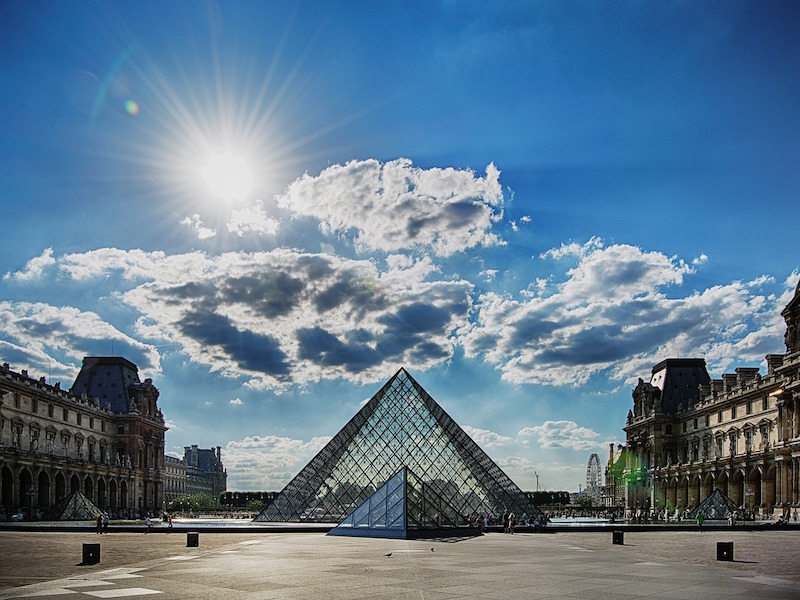

In [4]:
content_image = Image.open("Louvre.png")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C, G)$  

In Neural Style Transfer (NST), the goal is to ensure that the generated image G matches the content of the image C. This can be achieved by minimizing the content cost function, defined as:  

$$J_{content}(C, G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{\text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$  

* In this equation, $n_H$, $n_W$, and $n_C$ represent the height, width, and number of channels of the selected hidden layer, respectively, and are included in the normalization term of the cost.  
* The terms $a^{(C)}$ and $a^{(G)}$ correspond to the 3D volumes of activations in the chosen hidden layer for images C and G.  
* To compute $J_{content}(C, G)$, it is often practical to unroll these 3D volumes into 2D matrices for ease of manipulation.  
* Although this unrolling step is not strictly necessary for calculating $J_{content}$, it provides valuable practice for later computations, such as when calculating the style cost $J_{style}$.  


In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Retrieve dimensions from a_G 
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[1, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1, n_H * n_W, n_C])

    # compute the cost with tensorflow 
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

 

    return J_content

<a name='4-2'></a>
### 4.2 - Computing the Style Cost

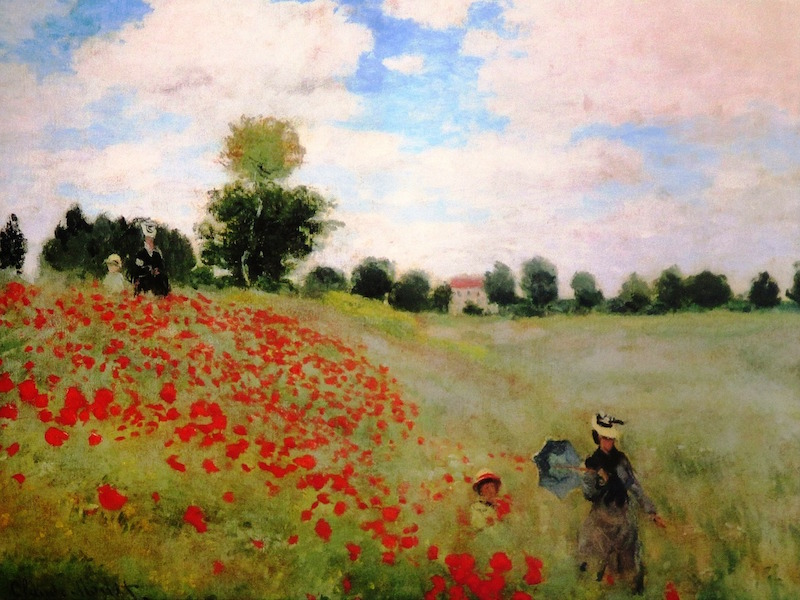

In [6]:
example = Image.open("Monet.png")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix  

#### Gram Matrix  
* The style matrix is commonly referred to as the "Gram matrix."  
* In linear algebra, the Gram matrix $G$ of a set of vectors $(v_{1},\dots ,v_{n})$ is defined as the matrix of dot products, with entries given by:  

  $${\displaystyle G_{ij} = v_{i}^T v_{j} = \text{np.dot}(v_{i}, v_{j})}.$$  

* This formulation allows $G_{ij}$ to measure the similarity between vectors $v_i$ and $v_j$. A higher dot product value indicates greater similarity, resulting in a larger value for $G_{ij}$.  

#### Clarification of the Variable $G$  
* A potential ambiguity arises due to the use of the variable $G$ in multiple contexts. Consistent with terminology in the literature:  
    * $G$ denotes the style matrix (Gram matrix).  
    * $G$ is also used to refer to the generated image.  
* To maintain clarity in this notebook, $G_{\text{gram}}$ will be used to denote the Gram matrix, while $G$ will continue to represent the generated image.  


#### Computation of the Gram Matrix $G_{\text{gram}}$  
The style matrix is computed by multiplying the "unrolled" filter matrix with its transpose:  

$$\mathbf{G}_{\text{gram}} = \mathbf{A}_{\text{unrolled}} \mathbf{A}_{\text{unrolled}}^T$$  

#### Interpretation of $G_{\text{gram},ij}$: Correlation of Features  
The resulting matrix has dimensions $(n_C, n_C)$, where $n_C$ represents the number of filters (channels). Each entry $G_{\text{gram},ij}$ quantifies the similarity between the activations of filter $i$ and filter $j$. A higher value indicates a stronger correlation between the detected patterns of the two filters.  

#### Interpretation of $G_{\text{gram},ii}$: Prevalence of Patterns or Textures  
* The diagonal elements $G_{\text{gram},ii}$ indicate the overall activation level of filter $i$.  
* For instance, if filter $i$ is responsible for detecting vertical textures, then $G_{\text{gram},ii}$ provides a measure of how frequently vertical textures appear in the image.  
* A larger value of $G_{\text{gram},ii}$ suggests a higher prevalence of the corresponding texture in the image.  

By capturing both the occurrence of individual features ($G_{\text{gram},ii}$) and the co-occurrence of different features ($G_{\text{gram},ij}$), the Gram matrix $G_{\text{gram}}$ serves as a quantitative representation of the style of an image.  


In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.linalg.matmul(A, tf.transpose(A))


    return GA

<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

The computation of the Gram matrix has now been established. The next objective is to minimize the difference between the Gram matrix of the "style" image $S$ and the Gram matrix of the "generated" image $G$.  

* At this stage, a single hidden layer activation $a^{[l]}$ will be used.  
* The style cost function for this layer is defined as:  

$$J_{\text{style}}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{\text{gram},ij} - G^{(G)}_{\text{gram},ij})^2\tag{2} $$  

where:  
* $G_{\text{gram}}^{(S)}$ represents the Gram matrix of the "style" image.  
* $G_{\text{gram}}^{(G)}$ represents the Gram matrix of the "generated" image.  
* This cost function is computed using the activations from a specific hidden layer in the network, denoted as $a^{[l]}$.  

Minimizing this cost function encourages the generated image to capture the texture and patterns of the style image while maintaining the content structure.  


In [8]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G 
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) 
    a_S = tf.reshape(tf.transpose(a_S), shape=[n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G), shape=[n_C, n_H * n_W])

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = 1/(4*(n_C*n_H*n_W)**2)*tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    return J_style_layer

<a name='4-2-3'></a>  
#### 4.2.3 - Style Weights  

* Up to this point, the style has been captured using a single layer.  
* Improved results can be achieved by incorporating style costs from multiple layers.  
* Each layer is assigned a weight ($\lambda^{[l]}$) that determines its contribution to the overall style representation.  
* After completing this exercise, different weight configurations can be explored to observe their effect on the generated image $G$.  
* By default, equal weights are assigned to all layers, ensuring that they sum to 1:  

  $$\sum_{l}^L\lambda^{[l]} = 1.$$  


Start by listing the layer names:

In [9]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The output of the layer `block5_conv4` can now be examined. This layer will later be defined as the content layer, serving as a representation of the image.  


In [10]:
vgg.get_layer('block5_conv4').output

<tf.Tensor 'block5_conv4/Relu:0' shape=(None, 25, 25, 512) dtype=float32>

Now choose layers to represent the style of the image and assign style costs:

In [11]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.


In [12]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

The selection of coefficients for each layer plays a crucial role in determining the influence of different layers on the generated image.  

* Deeper layers capture higher-level features, which are less spatially localized within the image.  
* To achieve a softer adherence to the style image, larger weights can be assigned to deeper layers, while smaller weights are given to the earlier layers.  
* Conversely, to enforce a stronger adherence to the style image, smaller weights can be assigned to deeper layers, with larger weights given to the earlier layers.  

By adjusting these weights, the balance between structural coherence and stylistic influence can be controlled.   



<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

The final step involves defining a cost function that simultaneously minimizes both the style and content costs. This is formulated as:  

$$J(G) = \alpha J_{\text{content}}(C,G) + \beta J_{\text{style}}(S,G)$$  

where:  
* $\alpha$ controls the relative importance of content preservation in the generated image.  
* $\beta$ controls the influence of style transfer.  

By adjusting these hyperparameters, the balance between content and style in the generated image can be fine-tuned.  



In [13]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha*J_content + beta*J_style

   

    return J

<a name='5'></a>
## 5 - Solving the Optimization Problem

The complete implementation of Neural Style Transfer (NST) can now be assembled by integrating all components.  

The program will perform the following steps:  

1. Load the content image.  
2. Load the style image.  
3. Randomly initialize the image to be generated.  
4. Load the pre-trained VGG19 model.  
5. Compute the content cost.  
6. Compute the style cost.  
7. Compute the total cost.  
8. Define the optimizer and set the learning rate.  

Each of these steps will now be examined in detail.  

<a id='part(4)'></a>  


<a name='5-1'></a>
### 5.1 Load the Content Image

(1, 400, 400, 3)


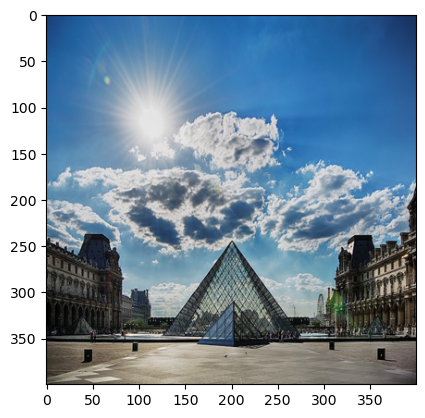

In [14]:
content_image = np.array(Image.open("Louvre.png").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image

(1, 400, 400, 3)


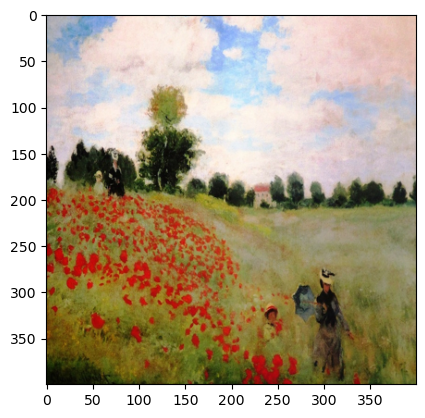

In [15]:
style_image =  np.array(Image.open("Monet.png").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>  
### 5.3 - Random Initialization of the Image to be Generated  

The "generated" image is initialized as a noisy image that shares a slight correlation with the content image.  

* The generated image is initialized to be primarily noisy, with a slight correlation to the content image.  
* This initialization strategy helps to accelerate the process of aligning the content of the generated image with the content of the reference image.  

This approach facilitates faster convergence during the optimization process.  


(1, 400, 400, 3)


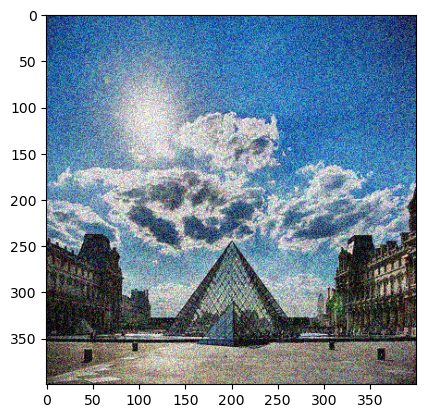

In [16]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model

In [17]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model.

In [18]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [19]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

<a name='5-5'></a>  
### 5.5 - Compute Total Cost  

<a name='5-5-1'></a>  
#### 5.5.1 - Compute the Content Image Encoding ($a_C$)  

The model has been built, and now the content cost can be computed by encoding the content image using the appropriate hidden layer activations. This encoding will be stored in the variable $a_C$. Later in the assignment, the same process will be applied to the generated image, with the corresponding hidden layer activations stored in the variable $a_G$. The layer `block5_conv4` will be used to compute this encoding. The following steps outline the process:

1. Set $a_C$ as the tensor representing the hidden layer activation for layer `block5_conv4` when applied to the content image.  


In [20]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S)

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [21]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that will be needed to display the images generated by the style transfer model.

In [22]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [23]:
# Ensure generated_image is a tf.Variable
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Initialize generated_image as a tf.Variable outside train_step
generated_image = tf.Variable(generated_image)

def train_step(generated_image):
    if not isinstance(generated_image, tf.Variable):
        generated_image = tf.Variable(generated_image)

    with tf.GradientTape() as tape:
        # Compute a_G as the VGG model outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)

        # Compute the total cost
        J = total_cost(J_content, J_style)

    # Compute gradients
    grad = tape.gradient(J, generated_image)

    # Apply gradients
    optimizer.apply_gradients([(grad, generated_image)])

    # Clip the values of the image to maintain pixel range [0, 1]
    generated_image.assign(clip_0_1(generated_image))

    # Return the total cost for monitoring
    return J


<a name='5-6'></a>  
### 5.6 - Train the Model  

Execute the following cell to generate an artistic image. This process typically takes around 3 minutes on a GPU for 2500 iterations. Neural Style Transfer is generally optimized using GPUs for improved performance.  

Increasing the learning rate can accelerate the style transfer process, although it may reduce the overall quality of the generated image.  


Epoch 0 


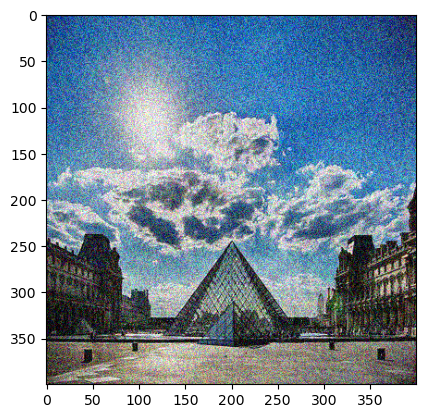

Epoch 250 


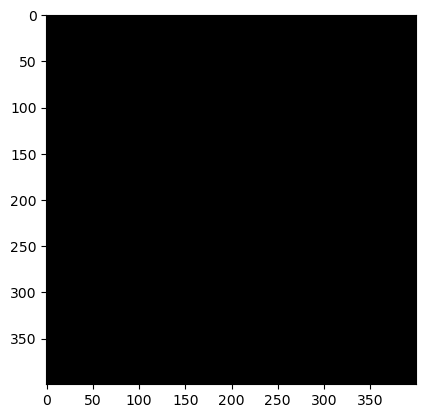

KeyboardInterrupt: 

In [24]:
# Show the generated image at some epochs
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        # image.save(f"output/image_{i}.jpg")
        plt.show()

Now, run the following code cell to see the results!

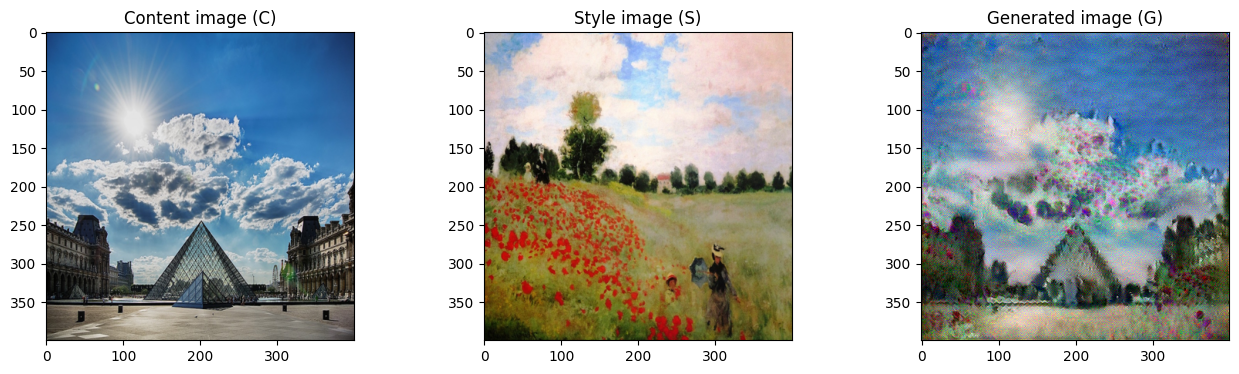

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image (C)')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image (S)')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image (G)')
plt.show()

Here are some ideas on how to tune the hyperparameters:
- Learning rate 
- To select different layers to represent the style, redefine `STYLE_LAYERS`
- To alter the number of iterations you want to run the algorithm, try changing `epochs` given in Section 5.6.
- To alter the relative weight of content versus style, try altering alpha and beta values
